# Double Pipe Heat Exchanger


## Experimental Goals

There are three basic calculations for heat exchanger design.

* **Rating.** Given the size, geometry, entering flowrates and streaam temperatures, compute the heat transferred.

* **Performance.** Given measurements of stream flowrates and temperatures, estimate the heat transfer coefficient.

* **Sizing.** Given the heat transfer requirements and stream flowrates, compute the required size and other design parameters. Sizing calculations generally require consideration of heat exchanger geometry, economics, and is considerably more complex thaan rating or performance calculations.

In this experiment, you will conduct experiments and gather data needed characterize heat exchanger performance to create a preditive model for rating calculations. You will then test your models ability to predict heat exchanger performance for other operating conditions.


## Co-Current Operation

### Rating Calculations

Consider a heat exchanger in a co-current configuration. Label one end $z=0$ and the other $z=1$. $z$ changes continuously from 0 to 1 over the length of the heat exchanger. If the cross-sectional for heat transfer is constant then

$$dA = A dz$$

where $A$ is the total area for heat transfer. According to the Second Law of Thermodynamics, heat transfers from the hot stream to the cold stream. A model for differential amount of heat transferred, $dQ$ over a length $dz$ is

$$dQ = UA (T_h - T_c) dz$$

where the temperture difference $T_h - T_c$ is the driving force for heat transfer. 

In a co-current configuration, let $\dot{q}_h$ and $\dot{q}_c$ denote the volumetric flow in the positive $z$ direction. Heat transfer results in a cooling of the hot stream and a waarming of the cold stream relative to the same direction.

\begin{align*}
-\rho_h\dot{q}_h C_{p,h} dT_h & = dQ \\
\rho_c\dot{q}_c C_{p,c} dT_c & = dQ
\end{align*}

where $\rho_h$ and $\rho_c$ refer to density of the hot and cold streams, and $C_{p,h}$ and $C_{p,c}$ are specific heat capacities. In co-current operation the temperature of both inlet flows are known at $z=0$. After substitution for $dQ$, the temperature profile is  given by a pair of first order differential equations with  initial conditions for $T_h(0)$ and $T_c(0)$

\begin{align*}
\frac{dT_h}{dz} & = -\frac{UA}{\rho_h\dot{q}_hC_{p,h}}(T_h - T_c)  & T_h(z=0) = T_{h,0}\\
\frac{dT_c}{dz} & = \frac{UA}{\rho_c\dot{q}_cC_{p,c}}(T_h - T_c) & T_c(z=0) = T_{c, 0}
\end{align*}

This is an initial value problem of two differential equations that can be solved numerically with ``scipy.integrate.solve_ivp`` as demonstrated below. 

The results of the temperature calculation can be used to complete the rating calculation.

\begin{align*}
Q_h & = \rho_h\dot{q}_h C_{p,h} (T_{h,0} - T_{h,1}) \\
Q_c & = \rho_c\dot{q}_c C_{p,c} (T_{c,1} - T_{c,0})
\end{align*}

where we expect $Q = Q_h = Q_c$ at steady state and with negligible heat losses.


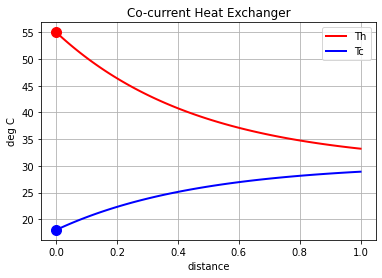

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# parameter values
A = 0.5       # square meters
U = 2000      # watts/square meter/deg C
qh = 600      # liter/hour
qc = 1200     # liter/hour
Cp = 4184     # Joules/kg/deg C    
rho = 1.0     # 1 kg/liter

# feed temperatures
Th0 = 55.0
Tc0 = 18.0

# differential equation model
def deriv(z, y):
    Th, Tc = y
    dTh = -U*A*(Th - Tc)/((rho*qh/3600)*Cp)
    dTc =  U*A*(Th-Tc)/((rho*qc/3600)*Cp)
    return [dTh, dTc]

# initial conditions
IC = [Th0, Tc0]

# evaluate solution
soln = solve_ivp(deriv, [0, 1], IC, max_step=0.01)

# plot solution
df = pd.DataFrame(soln.y.T, columns=["Th", "Tc"])
df["z"] = soln.t
ax = df.plot(x="z", style={"Th" : "r", "Tc" : "b"}, lw=2,
    title="Co-current Heat Exchanger", xlabel="distance", ylabel="deg C", grid=True)
ax.plot(0, df.loc[0, "Th"], 'r.', ms=20)
ax.plot(0, df.loc[0, "Tc"], 'b.', ms=20)

### Measuring Heat Transfer Coefficient

An analytical solution for the difference $T_h - T_c$ is possible for this system of equations. Subtracting the second equation from the first gives

$$\frac{d(T_h - T_c)}{dz} = -UA\left(\frac{1}{\rho_h\dot{q}_hC_{p,h}} + \frac{1}{\rho_c\dot{q}_cC_{p,c}}\right) (T_h - T_c)$$

This is a first-order linear differentiaal equation with constant coefficients that can be solved by a separation of variables. One form of the solution is

$$\ln \frac{T_h - T_c}{T_{h,0} - T_{c,0}} = -UA\left(\frac{1}{\rho\dot{q}_hC_{p,h}} + \frac{1}{\rho\dot{q}_cC_{p,c}}\right)z$$

where $T_h$ and $T_c$ are functions of $z$ on the interval $0 \leq z \leq 1$.

An overall balance for the total heat transferred between the hot and cold streams is given by

\begin{align*}
Q_h & = \rho\dot{q}_h C_{p,h} (T_{h,0} - T_{h,1}) \\
Q_c & = \rho\dot{q}_c C_{p,c} (T_{c,1} - T_{c,0})
\end{align*}

Rearranging

\begin{align*}
\frac{1}{\rho\dot{q}_hC_{p,h}} & = \frac{T_{h,0} - T_{h,1}}{Q_h} \\
\frac{1}{\rho\dot{q}_cC_{p,c}} & = \frac{T_{c,1} - T_{c,0}}{Q_c}
\end{align*}

At steady-state $Q_h = Q_c$. With a little more algebra this leaves 

$$Q = UA \frac{(T_{h,1} - T_{c,1}) - (T_{h,0} - T_{c,0})}{\ln \frac{T_{h,1} - T_{c,1}}{T_{h,0} - T_{c,0}}}$$

The temperature dependent term multiplying $UA$ is call the **log mean temperature difference**.

$$\text{LMTD} = \frac{(T_{h,1} - T_{c,1}) - (T_{h,0} - T_{c,0})}{\ln \frac{T_{h,1} - T_{c,1}}{T_{h,0} - T_{c,0}}}$$

Given experimental data, these relationships can be used to estimate the heat transfer coefficient $U$ from steady-state measurements of inlet and outlet temperataures and heat duty.

$$U = \frac{Q}{A \cdot \text{LMTD}}$$

The following code provides estimates the value of $U$ from experimental data in two steps. The first step uses the temperatures measured at both ends of the exchanger and the measured heat duty to compute the LMTD and $U$. The second step refines the estimate by fitting a model to the experimental results.

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fmin

# known parameter values
A = 5.0
qh = 600
qc = 1200
Cp = 4.0
rho = 1.0

# experimental data
z_expt = np.linspace(0, 1, 5)
Th_expt = np.array([55.0, 48.0, 42.0, 38.0, 33.0])
Tc_expt = np.array([18.0, 22.0, 25.0, 28.0, 29.0])

# LMTD calculation of heat transfer coefficient
Th0, Th1 = Th_expt[0], Th_expt[-1]
Tc0, Tc1 = Tc_expt[0], Tc_expt[-1]

# compute heat duty
Qh = rho*qh*Cp*(Th0 - Th1)
Qc = rho*qc*Cp*(Tc1 - Tc0)
Q = (Qh + Qc)/2
print(f"Heat duty = {Q:.1f} watts")

# compute number of transfer units
NTU = np.log((Th1 - Tc1)/(Th0 - Th1))

# estimate heat transfer coefficient
LMTD = ((Th1 - Tc1) - (Th0 - Tc0))/NTU
U = Q / (LMTD * A)

# display results
print(f"NTU = {-NTU:.2f}")
print(f"LMTD = {LMTD:.2f} deg C")
print(f"U (LMTD estimate) = {U:.1f} watt/deg C/m**2")

Heat duty = 52800.0 watts
NTU = 1.70
LMTD = 19.36 deg C
U (LMTD estimate) = 545.5 watt/deg C/m**2


Fitting temperature profiles

Optimization terminated successfully.
         Current function value: 8.273495
         Iterations: 75
         Function evaluations: 141
U (model fit) = 554.4 watt/deg C/m**2


<AxesSubplot:title={'center':'Co-current Heat Exchanger: U = 554.4 watts/deg/m**2'}, xlabel='fractional distance z', ylabel='deg C'>

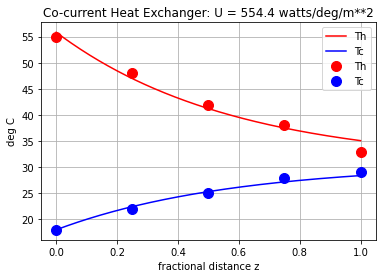

In [18]:
# initial estimate of fitted parameters
p_estimate = [U, Th0, Tc0]

# simulate double pipe heat exchange given parameter vector p
def double_pipe_cocurrent(z_eval, parameters):
    U, Th0, Tc0 = parameters
    def deriv(z, y):
        Th, Tc = y
        return [-U*A*(Th - Tc)/(rho*qh*Cp), U*A*(Th-Tc)/(rho*qc*Cp)]
    soln = solve_ivp(deriv, [0, 1], [Th0, Tc0], t_eval=z_eval, max_step=0.01)
    Th = soln.y[0,:]
    Tc = soln.y[1,:]
    return Th, Tc
 
# compute residuals between experiment and model
def residuals(p):
    Th_pred, Tc_pred = double_pipe_cocurrent(z_expt, p)
    return sum((Th_expt - Th_pred)**2) + sum((Tc_expt - Tc_pred)**2)

# minimize residuals
p_min = fmin(residuals, p_estimate)
U_min = p_min[0]
print(f"U (model fit) = {U_min:.1f} watt/deg C/m**2")

# compute temperature profile using the best least squares fit
z_eval = np.linspace(0, 1, 201)
Th_pred, Tc_pred = double_pipe_cocurrent(z_eval, p_min)

# plot solution
df = pd.DataFrame(np.array([z_eval, Th_pred, Tc_pred]).T, columns=["z", "Th", "Tc"])
ax = df.plot(x="z", style={"Th" :  "r", "Tc" : "b"})

expt = pd.DataFrame(np.array([z_expt, Th_expt, Tc_expt]).T, columns=["z", "Th", "Tc"])
expt.plot(ax=ax, x="z", style={"Th" : "r.", "Tc" : "b."}, ms=20, grid=True,
          xlabel="fractional distance z", ylabel="deg C", title=f"Co-current Heat Exchanger: U = {U_min:.1f} watts/deg/m**2")

### Rating, revisited

Integrating

$$dQ = UA (T_h - T_c) dz$$

So that 

$$Q = UA \int_0^1 (T_h(z) - T_c(z)) dz$$

We have a solution for the difference $T_h(z) - T_c(z)$ that can be written

$$T_h(z) - T_c(z) = (T_{h,0} - T_{c,0}) \exp\left(-UA\left(\frac{1}{\rho\dot{q}_hC_{p,h}} + \frac{1}{\rho\dot{q}_cC_{p,c}}\right)z\right)$$

Performing the integrations produces a rating equation

\begin{align*}
Q & = UA(T_{h,0} - T_{c,0}) \int_0^1 \exp\left(-UA\left(\frac{1}{\rho\dot{q}_hC_{p,h}} + \frac{1}{\rho\dot{q}_cC_{p,c}}\right)z\right)dz \\
& = -\frac{T_{h,0} - T_{c,0}}{\frac{1}{\rho\dot{q}_hC_{p,h}} + \frac{1}{\rho\dot{q}_cC_{p,c}}}\left[\exp\left(-UA\left(\frac{1}{\rho\dot{q}_hC_{p,h}} + \frac{1}{\rho\dot{q}_cC_{p,c}}\right)z\right)\right]\biggr\rvert_0^1 \\
\end{align*}

which provides a solution

\begin{align*}
\implies Q & = \frac{T_{h,0} - T_{c,0}}{\frac{1}{\rho\dot{a}_hC_{p,h}} + \frac{1}{\rho\dot{q}_cC_{p,c}}}\left[1 - \exp\left(-UA\left(\frac{1}{\rho\dot{q}_hC_{p,h}} + \frac{1}{\rho\dot{q}_cC_{p,c}}\right)\right)\right]
\end{align*}

This is an equation that predicts the heat transfer in terms of the known stream input temperatures and flowrates.

## Counter-Current Operation

### Rating Calculations

Counter-current operation requires a different method of solution. For this case we will assume the cold water stream enters at $z=0$ while the hot stream enters at $z=1$. As before, heat is transferred from the hot stream to the cold stream

$$dQ = UA (T_h - T_c) dz$$

Because of the counter-current flow, $T_h$ and $T_c$ both increase in the direction of increasaing $z$

\begin{align*}
\rho\dot{q}_h C_{p,h} dT_h & = dQ \\
\rho\dot{q}_c C_{p,c} dT_c & = dQ
\end{align*}

Substitution yields

\begin{align*}
\frac{dT_h}{dz} & = \frac{UA}{\rho\dot{q}_hC_{p,h}}(T_h - T_c) & T_h(z=1) = T_{h,1} \\
\frac{dT_c}{dz} & = \frac{UA}{\rho\dot{q}_cC_{p,c}}(T_h - T_c) & T_c(z=0) = T_{c,0}
\end{align*}

where $T_c(0)$ and $T_h(1)$ are specified at opposite ends of the heat exchanger. For this reason, these equations for the counter-current heat exchanger comprise a two point boundary value problem.

[``scipy.integrate.solve_bvp``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html)

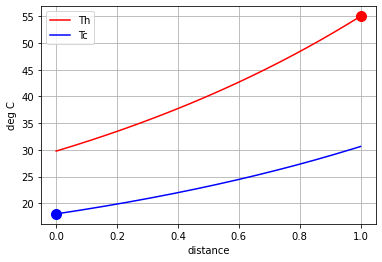

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp

# parameter values
A = 5
U = 700
qh = 600
qc = 1200
Cp = 4.0
rho = 1.0

# feed temperatures
Th1 = 55.0
Tc0 = 18.0

# number of points
n = 201

# differential equation model
def deriv(z, y):
    Th, Tc = y
    return [U*A*(Th - Tc)/(rho*qh*Cp), U*A*(Th-Tc)/(rho*qc*Cp)]

def bc(y0, y1):
    return [y1[0] - Th1,  # bc for Th at z=1
            y0[1] - Tc0]  # bc for Tc at z=0

# evaluate solution
z_eval = np.linspace(0, 1, n)
y_guess = (Th1 + Tc0)*np.ones((2, n))/2  # initial guess
soln = solve_bvp(deriv, bc, z_eval, y_guess)

# plot solution
df = pd.DataFrame({"z" : z_eval, "Th" : soln.y[0, :], "Tc" : soln.y[1, :]})
ax = df.plot(x="z", style={"Th" : "r", "Tc" : "b"}, xlabel="distance", ylabel="deg C", grid=True)
ax.plot(1, df.iloc[-1, 1], "r.", ms=20)
ax.plot(0, df.iloc[0, 2], "b.", ms=20)